# Test de Tukey para detección de anomalías

Este ejemplo muestra el uso de Test de Tukey o cálculo del rango intercuartil (IQR)  para la detección de anomalías. 

Para generar los datos utilizaremos funciones de la librería PyOD.


Paso 1. Instalamos la librería PyOD

In [ ]:
!pip install pyod

Paso 2. Importamos las librerías que necesitamos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from pyod.utils.data import generate_data
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

Paso 3. Generamos datos sintéticos. En este caso, vamos a trabajar con datos de entrenamiento y datos de test. Para tener un conjunto considerable de datos de forma rápida, vamos a generarlos utilizando el método *generate_data* que nos permite definir el número de instancias, las dimensiones y el porcentaje de outliers que queremos.

Rercordamos que aunque el método no usará el atributo que determina si es una anomalía o no para realizar su procesamiento, las tenemos disponibles con la finalidad de comparar los resultados.

In [ ]:
# Porcentaje de outliers que vamos a considerar
contamination = 0.1

#Número de ejemplos de entrenamiento y test que vamos a utilizar
n_train = 200  
n_test = 100  

# Generamos los datos, considerando 2 dimensiones y las características anteriores
# Utilizamos como generador de datos aleatorios (random_state) la semilla 3, 
# para que en todas las pruebas obtengamos los mismos datos.
X_train, X_test, y_train, y_test = generate_data(n_train=n_train, n_test=n_test, n_features=2, behaviour='new', contamination=contamination,random_state=12)


Paso 4. Visualizamos los datos que hemos generado para train (entrenamiento) y test (prueba), lo representamos en diferente color los puntos que son anomalías de los que no.

In [ ]:
#Creamos una nueva variable DataFrame para que incorpore en los datos de entrenamiento
# el atributo la etiqueta de anomalía o no.
# Lo usamos solamente para la representación, los datos que usará el modelo sigue
#sin tener esa información
XY_train = pd.DataFrame({"Variable 1": X_train[:,0], "Variable 2": X_train[:,1], "Anomalía": y_train})

#Lo representamos gráficamente poniendo el color en función de si es anómalo o no
plt.scatter(XY_train['Variable 1'], XY_train['Variable 2'], c=XY_train['Anomalía'])
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.title("Distribución de los datos training")
plt.show()

#Creamos una nueva variable DataFrame para que incorpore en los datos de test 
# el atributo la etiqueta de anomalía o no solamente para la representación. 
# El conjunto de test que usaremos en el modelo sigue sin tener esa información
XY_test = pd.DataFrame({"Variable 1": X_test[:,0], "Variable 2": X_test[:,1], "Anomalía": y_test})

#Lo representamos gráficamente poniendo el color en función de si es anómalo o no
plt.scatter(XY_test['Variable 1'], XY_test['Variable 2'], c=XY_test['Anomalía'])
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.title("Distribución de los datos test")
plt.show()

Paso 5. Vamos a visualizar el boxplot que nos va a permitir ver 
todos los valores visualmente en los que se basa este test. Haremos un bloxplot para cada dimensión ya que se trata de un método univariante

In [ ]:
#Adaptamos el tamaño del gráfico para visualizarlo mejor
plt.figure(figsize=(12, 3))
#Cofiguramos el boxplot en horizontal 
plt.boxplot(XY_train['Variable 1'], vert=False)
#Título del gráfico
plt.title("Boxplot Variable 1")
#Mostramos el boxplog
plt.show()

#Adaptamos el tamaño del gráfico para visualizarlo mejor
plt.figure(figsize=(12, 3))
#Cofiguramos el boxplot en horizontal 
plt.boxplot(XY_train['Variable 2'], vert=False)
#Título del gráfico
plt.title("Boxplot Variable 2")
#Mostramos el boxplog
plt.show()


**Comentario boxplot:** podemos ver que en las dos variables se encuentran valores anómalos fuera de los rangos establecidos por el diagrama de cajas (boxplot)

Paso 6. Aplicamos el método de Tukey
Para descubrir y filtrar dichos valores atípicos en el conjunto de datos, se va a crear una función que nos indicará los valores atípicos de acuerdo con el test de Turkey. En la función, primero debemos averiguar el valor de IQR que se puede calcular encontrando la diferencia entre los valores del tercer y primer cuartil. En segundo lugar, seleccionaremos los valores que están fuera del rango y los marcaremos como anomalías.

Esto se realizará para cada dimensión.

In [ ]:
#Primera dimensión en los datos de train
# Calculamos el primer, segundo y tercer cuartil, que se corresponde con los valores de la caja
Q1_d1 = np.percentile(X_train[:,0], 25, interpolation = 'midpoint')  
Q2_d1 = np.percentile(X_train[:,0], 50, interpolation = 'midpoint')  
Q3_d1 = np.percentile(X_train[:,0], 75, interpolation = 'midpoint') 

#Segunda dimensión en los datos de train
#Calculamos el primer, segundo y tercer cuartil, que se corresponde con los valores de la caja
Q1_d2 = np.percentile(X_train[:,1], 25, interpolation = 'midpoint')  
Q2_d2 = np.percentile(X_train[:,1], 50, interpolation = 'midpoint')  
Q3_d2 = np.percentile(X_train[:,1], 75, interpolation = 'midpoint') 


#Los mostramos por pantalla
print('Q1 - 25 percentil de los datos (dimensión1), ', Q1_d1) 
print('Q2 - 50 percentil de los datos (dimensión1), ', Q2_d1) 
print('Q3 - 75 percentil de los datos (dimensión1), ', Q3_d1) 

print('Q1 - 25 percentil de los datos (dimensión2), ', Q1_d2) 
print('Q2 - 50 percentil de los datos (dimensión2), ', Q2_d2) 
print('Q3 - 75 percentil de los datos (dimensión2), ', Q3_d2) 


#Calculamos el rango intercuartílico (IQR) de cada dimensión y lo mostramos
IQR_d1 = Q3_d1 - Q1_d1
print('IQR (dimensión1): ', IQR_d1) 
IQR_d2 = Q3_d2 - Q1_d2
print('IQR (dimensión2): ', IQR_d2) 


#Calculamos los límites inferior y superior como Q1 - 1.5*IQR y Q3 + 1.5*IQR
# para cada dimensión y los mostramos.
inf_limite_d1 = Q1_d1 - 1.5 * IQR_d1 
sup_limite_d1 = Q3_d1 + 1.5 * IQR_d1 
print('inf_limite_d1', inf_limite_d1) 
print('sup_limite_d1', sup_limite_d1) 

inf_limite_d2 = Q1_d2 - 1.5 * IQR_d2 
sup_limite_d2 = Q3_d2 + 1.5 * IQR_d2 
print('inf_limite_d2', inf_limite_d2) 
print('sup_limite_d2', sup_limite_d2) 

#Vamos a establecer la variable y_train_pred y y_test_pred, para indicar
#los valores que predice este métodos en los datos de training y test.
#Cuando veamos la librería PyOD veremos que lo hace de forma similar.
y_train_pred = []
y_test_pred = []

#Para training
# si en cualquiera de las dimensiones de esa instancia se supera el umbral
# vamos a considerar que esa instancia es anómala valor 1 sino 0 (normal)
for x in X_train: 
    if ((x[0]> sup_limite_d1) or (x[0]<inf_limite_d1) or (x[1]> sup_limite_d2) or (x[1]<inf_limite_d2)): 
         y_train_pred.append(1)
    else:
         y_train_pred.append(0)

# Para test
# si en cualquiera de las dimensiones de esa instancia se supera el umbral
# vamos a considerar esa instancia es anómala valor 1 sino 0 (normal)
for x in X_test: 
    if ((x[0]> sup_limite_d1) or (x[0]<inf_limite_d1) or (x[1]> sup_limite_d2) or (x[1]<inf_limite_d2)): 
         y_test_pred.append(1)
    else:
         y_test_pred.append(0)


#Mostramos las etiquetas asignadas a cada instancia tanto reales como predichas 
print('Etiquetas reales datos train: ', y_train)
print('Etiquetas reales datos test: ', y_test)

print('Etiquetas predichas datos train: ', y_train_pred)
print('Etiquetas predichas datos test: ', y_test_pred)

Paso 7. Visualizamos los resultados para ver si el método ha reconocido adcuadamente todas las anomalías.

a) Visualizamos los datos reales y predichos para train

In [ ]:
#Creamos una nueva variable de training para que incorpore como atributo la etiqueta de anomalía
#predicha, con las anomalías reales ya lo hicimos en el paso 4 de visualización
XY_train_pred = pd.DataFrame({"Variable 1": X_train[:,0], "Variable 2": X_train[:,1], "Anomalía": y_train_pred})

# Creamos la figura para los datos predichos
# Agregamos los puntos en el plano y ponemos el color en función de la dimensión anomalía que hemos añadido en XY_train_pred
plt.scatter(XY_train_pred['Variable 1'], XY_train_pred['Variable 2'], c = XY_train_pred['Anomalía'], marker='o')
plt.title("Conjunto de train - Predicho")
# Mostramos el gráfico
plt.show()


# Creamos la figura para los datos reales
# Agregamos los puntos en el plano y ponemos el color en función de la dimensión Anomalia que hemos añadido en XY_train
plt.scatter(XY_train['Variable 1'], XY_train['Variable 2'], c = XY_train['Anomalía'], marker='o')
plt.title("Conjunto de train - Real")
# Mostramos el gráfico
plt.show()

b) Visualizamos ahora los datos reales y predichos para test

In [ ]:
#Creamos una nueva variable de test para que incorpore tanto las anomalías reales 
#como las predichas, con las anomalías reales ya lo hicimos en el paso 4 de visualización
XY_test_pred = pd.DataFrame({"Variable 1": X_test[:,0], "Variable 2": X_test[:,1], "Anomalía": y_test_pred})

# Creamos la figura para los datos predichos
# Agregamos los puntos en el plano y ponemos el color en función de la dimensión anomalía que hemos añadido en XY_test_pred
plt.scatter(XY_test_pred['Variable 1'], XY_test_pred['Variable 2'], c = XY_test_pred['Anomalía'], marker='o')
plt.title("Conjunto de test - Predicho")
# Mostramos el gráfico
plt.show()


# Creamos la figura paralos datos reales
# Agregamos los puntos en el plano y ponemos el color en función de la dimensión Anomalia que hemos añadido en XY_test
plt.scatter(XY_test['Variable 1'], XY_test['Variable 2'], c = XY_test['Anomalía'], marker='o')
plt.title("Conjunto de test - Real")
# Mostramos el gráfico
plt.show()

**Comentario visualización:** se puede apreciar que en los datos de test se reconoce todas las anomalías que estaban presentes y en el training la mayoría de ellas.

Paso 8. Calculamos las medidas que hemos visto para evaluar el rendimiento del método, partiendo de la matriz de confusión y también usando directamente la librería skearn.metrics

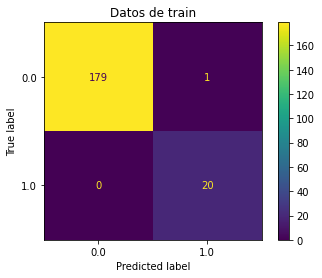

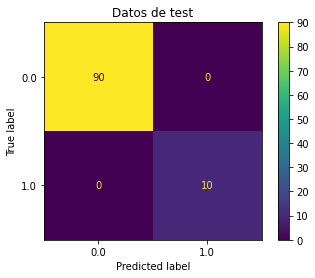

In [ ]:
#Mostramos la matriz de confusión para datos de train
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.title("Datos de train")
plt.show()

#Mostramos la matriz de confusión para datos de test
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title("Datos de test")
plt.show()


A continuación vamos a mostrar la curva ROC-AUC, sensibilidad, especificidad y precisión.

In [ ]:
#Calculamos las medidas para train
print('Medidas para train')
print('------------------')
#Calculamos la matriz de confusión
cm = confusion_matrix(y_train,y_train_pred)
print('Matriz de confusión : \n', cm)
total=sum(sum(cm))

#Calculamos sensibilidad y especificidad desde la matriz de confusión
sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensibilidad : ', sensitivity )
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Especificidad: ', specificity)
precision = cm[1,1]/(cm[1,1]+cm[0,1])
print('Precisión: ', precision)

#Calculamos las otras métricas desde la librería
print('ROC-AUC: ', roc_auc_score(y_train, y_train_pred, average=None))


#Calculamos las medidas para test
print('Medidas para test')
print('------------------')
#Calculamos la matriz de confusión
cm = confusion_matrix(y_test,y_test_pred)
print('Matriz de confusión : \n', cm)
total=sum(sum(cm))

#Calculamos sensibilidad y especificidad desde la matriz de confusión
sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensibilidad : ', sensitivity )
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Especificidad: ', specificity)
precision = cm[1,1]/(cm[1,1]+cm[0,1])
print('Precisión: ', precision)

#Calculamos las otras métricas desde la librería
print('ROC-AUC: ', roc_auc_score(y_test, y_test_pred, average=None))


Medidas para train
------------------
Matriz de confusión : 
 [[179   1]
 [  0  20]]
Sensibilidad :  1.0
Especificidad:  0.9944444444444445
Precisión:  0.9523809523809523
ROC-AUC:  0.9972222222222222
Medidas para test
------------------
Matriz de confusión : 
 [[90  0]
 [ 0 10]]
Sensibilidad :  1.0
Especificidad:  1.0
Precisión:  1.0
ROC-AUC:  1.0


**Comentario métricas:** se puede ver que para los datos de test se consigue una clasificación perfecta, donde la clasificación de las anomalías es de un 100% (sensibilidad), la clasificación de las clases normales, también es un 100% (especificidad), el área bajo la curva es también perfecta (valor 1.0) y el total de aciertos de la clase anómala con respecto a todo lo que se ha dicho que era anomálo es también del 100%.

Los datos de entrenamiento también han sido muy satisfactorios donde solamente se ha cometido un error, un dato que realmente era normal se ha clasificado como anómalo, que es el error que hemos comentado que en situtaciones catastróficas se prefiere, este fallo hace que la precisión y la especificidad sean algo más bajas del 100%, pero son unos resulados relevantes para detectar estas anomalías.
